# Классификация текстов

Построение классификатора текстов. Предсказание эмоциональной окраски твиттов о коронавирусе



In [ ]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
29679,40235,85187,"Nashville, TN USA",09-04-2020,Chainstore Age - Walgreens expands consumer te...,Positive
20710,29066,74018,"Los Angeles, CA",31-03-2020,"Some workers are able to work from home, pay f...",Negative
2711,7079,52031,NaN,18-03-2020,"During the COVID-19 crisis, this account will ...",Extremely Positive
26887,36765,81717,UK,07-04-2020,People with vision impairments are struggling ...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Подготовка данных

Целевая переменная находится в колонке `Sentiment`.  Её необходимо бинаризовать: 1 - у твитта положительная эмоциональная окраска и 0 - отрицательная.

In [ ]:
df.Sentiment = df.Sentiment.apply(lambda x: 1 if x == 'Positive' else 0)

Сбалансированы классов

In [ ]:
df.Sentiment.value_counts()

,count
Sentiment,
0,22022
1,11422


Классы несбалансированы, поскольку нулевого класса в два раза больше, чем первого.

Пропуски в данных. Пропуски заполняются строкой 'Unknown'.

In [ ]:
df.isnull().sum()

,0
UserName,0
ScreenName,0
Location,7049
TweetAt,0
OriginalTweet,0
Sentiment,0


In [ ]:
df = df.fillna('Unknown')

Разделение данных на обучающие и тестовые в соотношении 7 : 3

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Токенизация

Построение словаря на основе обучающей выборки и подсчёт количества встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
dictionary = {}
for i in train.OriginalTweet:
    for j in i.lower().split():
        if j in dictionary:
            dictionary[j] += 1
        else:
            dictionary[j] = 1
dictionary

{'why': 654,
 'we': 3787,
 'still': 763,
 'want': 487,
 'to': 23373,
 'buy': 748,
 'so': 1837,
 'much': 482,
 'stuff': 106,
 'during': 1908,
 'quarantine': 154,
 'https://t.co/1m881cwfuv': 1,
 '#shopping': 121,
 '#covid_19': 1660,
 '#online': 40,
 'with': 4063,
 'driving': 77,
 'even': 682,
 'more': 2008,
 'usage': 22,
 'a': 11737,
 'strong': 93,
 'strategy': 33,
 'is': 7383,
 'critical': 156,
 'now': 1349,
 'then': 435,
 'ever': 179,
 'luckily': 8,
 'and': 14684,
 'april': 163,
 '16': 36,
 'webinar': 65,
 'will': 2726,
 'dive': 10,
 'into': 666,
 'growing': 84,
 'app': 52,
 'awareness': 32,
 'targeting': 9,
 'high': 408,
 'lifetime': 4,
 'value': 79,
 'users': 19,
 '@canon_india': 16,
 'i': 5340,
 'am': 424,
 'very': 418,
 'happy..': 1,
 'great': 409,
 'job': 242,
 'by': 2236,
 '#canonforcommunity': 5,
 'https://t.co/z0intks34x': 1,
 'the': 26815,
 'u.s': 8,
 'national': 123,
 'debt': 68,
 'likely': 170,
 'exceed': 14,
 '$30': 7,
 'trillion': 21,
 'after': 886,
 'unprecedented': 89,
 

Размер словаря

In [ ]:
len(dictionary)

79755

Самые популярные токены с количеством встреч каждого из них

In [ ]:
dictionary = dict(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))

In [ ]:
counter = 0
for i in dictionary.items():
    print(i[0], i[1], sep=': ')
    counter += 1
    if counter == 10:
        break

the: 26815
to: 23373
and: 14684
of: 13012
a: 11737
in: 11198
for: 8566
#coronavirus: 8223
is: 7383
are: 7050


Артикли и служебные части речи являются общеупотребительными в речах людей, а коронавирус был на слуху в 2020 году

Удаление стоп-слов из словаря и вывод популярных токенов

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

for i in stopwords.words('english'):
    if i in dictionary:
        del dictionary[i]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
counter = 0
for i in dictionary.items():
    print(i[0], i[1], sep=': ')
    counter += 1
    if counter == 10:
        break

#coronavirus: 8223
prices: 3891
food: 3820
grocery: 3469
supermarket: 3288
people: 3175
covid-19: 3173
store: 3155
#covid19: 2471
&amp;: 2314


**Остался коронавирус и самостоятельные части речи, что логично ведь служебные части речи являются стоп-словами из-за своей общеупотребительности**

Cамые непопулярные слова

In [ ]:
counter = 0
for i in sorted(dictionary.items(), key=lambda x: x[1]):
    print(i[0], i[1], sep=': ')
    counter += 1
    if counter == 20:
        break

https://t.co/1m881cwfuv: 1
happy..: 1
https://t.co/z0intks34x: 1
mnuchinãâs: 1
brink.: 1
https://t.co/jmobv8z0u0: 1
university's: 1
teaching.): 1
@catholicpres: 1
@catholicuniv: 1
https://t.co/evqby035wf: 1
https://t.co/riqrhxxeim: 1
@@ballardspahrll: 1
#aca: 1
easier...take: 1
ãânecessaryãâ: 1
https://t.co/0fmsmlgepm: 1
husted:: 1
irishman: 1
#happystpatricksday!: 1


**Самые непопулярные слова - это индивидаульные твиттер-ссылки и слова с непривычными для них знаками препинаниями, а также что-то вроде тегов. Дополнительно с ними работать необязательно, ведь их в целом немного. С другой стороны, твиттер-ссылок должно быть очень много, поэтому их неплохо бы обрабатывать при токенизации**

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk

In [ ]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
new_dictionary = {}
for i in train.OriginalTweet:
    for j in tw.tokenize(i):
        if j in new_dictionary:
            new_dictionary[j] += 1
        else:
            new_dictionary[j] = 1
new_dictionary

{'Why': 278,
 'we': 2412,
 'still': 705,
 'want': 455,
 'to': 22933,
 'buy': 744,
 'so': 1402,
 'much': 489,
 'stuff': 141,
 'during': 1753,
 'quarantine': 174,
 'https://t.co/1m881CwFUv': 1,
 '#shopping': 103,
 '#Covid_19': 1463,
 '#Online': 12,
 'With': 346,
 'driving': 70,
 'even': 588,
 'more': 1969,
 'usage': 24,
 'a': 11045,
 'strong': 129,
 'strategy': 34,
 'is': 7162,
 'critical': 137,
 'now': 1476,
 'then': 386,
 'ever': 213,
 'Luckily': 11,
 'and': 14354,
 'April': 184,
 '16': 48,
 'webinar': 57,
 'will': 2561,
 'dive': 11,
 'into': 664,
 'growing': 88,
 'app': 52,
 'awareness': 30,
 'targeting': 9,
 'high': 396,
 'lifetime': 6,
 'value': 85,
 'users': 20,
 '@Canon_India': 13,
 'I': 5235,
 'am': 418,
 'very': 355,
 'happy': 64,
 '..': 404,
 'Great': 125,
 'job': 266,
 'by': 2176,
 '#CanonForCommunity': 5,
 'https://t.co/Z0intkS34x': 1,
 'The': 2516,
 'U': 278,
 '.': 24118,
 'S': 278,
 'national': 74,
 'debt': 76,
 'likely': 168,
 'exceed': 14,
 '$': 863,
 '30': 138,
 'Trillio

In [ ]:
counter = 0
for i in sorted(new_dictionary.items(), key=lambda x: x[1], reverse=True):
    print(i[0], i[1], sep=': ')
    counter += 1
    if counter == 10:
        break

the: 24337
.: 24118
to: 22933
,: 17571
and: 14354
of: 12904
a: 11045
in: 10573
?: 9524
for: 8228


**Остались знаки препинания и служебные части речи. Твиттер-ссылки и теги были успешно исключены, твиттер-токенизатор все-таки**

Удаление из словаря стоп-слов и пунктуационных знаков

In [ ]:
noize = stopwords.words('english') + list(punctuation)
for i in noize:
    if i in new_dictionary:
        del new_dictionary[i]

In [ ]:
counter = 0
for i in sorted(new_dictionary.items(), key=lambda x: x[1], reverse=True):
    print(i[0], i[1], sep=': ')
    counter += 1
    if counter == 10:
        break

Â: 7415
: 7311
19: 7167
#coronavirus: 7143
I: 5235
: 4372
prices: 4281
COVID: 4218
food: 3795
store: 3691


**Осталась А с домиком и прямоугольник со знаком вопроса. Вероятно, последнее обозначало собой смайлик. Также остались обычные слова и коронавирус**

Удаление из словаря токенов из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Самые популярные и непопулярные слова

In [ ]:
for i in list(new_dictionary):
    if len(i) == 1 and ord(i) >= 128:
        del new_dictionary[i]

In [ ]:
counter = 0
for i in sorted(new_dictionary.items(), key=lambda x: x[1], reverse=True):
    print(i[0], i[1], sep=': ')
    counter += 1
    if counter == 10:
        break

19: 7167
#coronavirus: 7143
I: 5235
prices: 4281
COVID: 4218
food: 3795
store: 3691
supermarket: 3373
grocery: 3083
people: 3047


In [ ]:
counter = 0
for i in sorted(new_dictionary.items(), key=lambda x: x[1]):
    print(i[0], i[1], sep=': ')
    counter += 1
    if counter == 20:
        break

https://t.co/1m881CwFUv: 1
https://t.co/Z0intkS34x: 1
MnuchinÃ: 1
https://t.co/JmoBv8z0U0: 1
University's: 1
@CatholicPres: 1
@CatholicUniv: 1
https://t.co/EvQby035wF: 1
https://t.co/rIQrhxxeIM: 1
@BallardSpahrLL: 1
#training: 1
#aca: 1
https://t.co/0FmSmlGePM: 1
Irishman: 1
#HappyStPatricksDay: 1
Guiness: 1
https://t.co/18V0PYHwb7: 1
https://t.co/LS0g86i8PU: 1
https://t.co/oFVkejfF23: 1
https://t.co/Xoodgd2uLx: 1


**В топе популярных непонятные сингл-символы были удалены, остались обычные слова. В топе непопулярных нет больше слов с непривычными для них сочетаниями знаков препинания**-

Популярные хештеги с количеством встреч

In [ ]:
for i in sorted(new_dictionary.items(), key=lambda x: x[1], reverse=True):
    if i[0][0] == '#':
        print(i[0], i[1], sep=': ')

#coronavirus: 7143
#COVID19: 1844
#Covid_19: 1463
#Coronavirus: 1281
#COVID2019: 927
#toiletpaper: 657
#covid19: 568
#COVID: 542
#CoronaCrisis: 426
#CoronaVirus: 351
#SocialDistancing: 333
#CoronavirusPandemic: 236
#pandemic: 217
#CoronavirusOutbreak: 206
#covid_19: 195
#StayHomeSaveLives: 187
#supermarket: 175
#panicbuying: 175
#Covid19: 175
#lockdown: 174
#StayHome: 170
#StayAtHome: 170
#StopHoarding: 164
#CoronaVirusUpdate: 147
#COVID-19: 141
#retail: 138
#corona: 135
#covid19UK: 132
#socialdistancing: 130
#food: 123
#StopPanicBuying: 116
#handsanitizer: 112
#QuarantineLife: 107
#shopping: 103
#coronavirusuk: 100
#quarantine: 94
#Quarantine: 93
#sanitizer: 92
#covid: 84
#oil: 84
#ToiletPaper: 80
#staysafe: 77
#COVID_19: 76
#consumer: 75
#CoronavirusUSA: 74
#toiletpapercrisis: 74
#Corona: 71
#CoronavirusLockdown: 70
#economy: 70
#ToiletPaperPanic: 69
#grocery: 66
#panicbuyinguk: 65
#stayhome: 62
#StaySafe: 61
#ecommerce: 60
#virus: 56
#China: 56
#onlineshopping: 50
#Oil: 50
#CoronaCr

**Везде коронавирус и связанные с ним названия социальных являених и ограничений** .

Проделаемое то же самое для ссылок на сайт https://t.co

In [ ]:
for i in sorted(new_dictionary.items(), key=lambda x: x[1], reverse=True):
    if i[0].startswith('https://t.co'):
        print(i[0], i[1], sep=': ')

Выходные данные были обрезаны до нескольких последних строк (5000).
https://t.co/TzrRqgntJv: 1
https://t.co/Oji4PnIqC0: 1
https://t.co/2NLqKOoHnI: 1
https://t.co/VbZpEwSJeD: 1
https://t.co/VLJa9s7Poe: 1
https://t.co/wJ3YxNizxd: 1
https://t.co/OAMwwmrbkP: 1
https://t.co/LSiGhfFPIb: 1
https://t.co/3ZzsHaZwsE: 1
https://t.co/3tikdossiz: 1
https://t.co/EuAU1Zq2VY: 1
https://t.co/1vVFacVZtS: 1
https://t.co/6NOeCQZUS8: 1
https://t.co/YebmfSBM0X: 1
https://t.co/nWmAku3Zt8: 1
https://t.co/tQfCxKmSfD: 1
https://t.co/RdWjALWbeB: 1
https://t.co/YEnDvKaeIQ: 1
https://t.co/PQofZ4Mbd5: 1
https://t.co/Uco9Op1mXw: 1
https://t.co/5cYRMm7dsR: 1
https://t.co/5NO9BCdFWK: 1
https://t.co/a9MpBvNAgP: 1
https://t.co/IH9F2ivDXb: 1
https://t.co/MoUm1JWzdm: 1
https://t.co/h3cKx4WaiH: 1
https://t.co/SezKRbe8Hq: 1
https://t.co/qDxsRE2lfE: 1
https://t.co/KFcNZXvXAa: 1
https://t.co/x9ZEJtfHye: 1
https://t.co/y4rzEwPbIF: 1
https://t.co/6ARSlU1VhC: 1
https://t.co/1eGo40LUKO: 1
https://t.co/3Ay1cJCHE5: 1
https://t.co/0

**Популярность ссылок несранивама с популярностью хештегов, разумеется. Максимум встречаемости ссылок равен 5 - информация в таком случае не является полезной, если только не выявить какую-то закономерность в названии страничек после слэша и не сгруппировать впоследствии их**

Функция custom_tokenizer:



*   Приведение текста в нижний регистр
*   Применение TweetTokenizer для изначального выделения токенов
*   Удаление стоп-слов, пунктуации, токенов из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co

In [ ]:
def custom_tokenizer(text):
    if type(text) is pd.Series:
        text = text.to_string().lower()
    else:
        text = text.lower()
    tokens = TweetTokenizer().tokenize(text)
    noize = stopwords.words('english') + list(punctuation)
    tokens = [token for token in tokens if token not in noize and not (len(token) == 1 and ord(token) >= 128) and not token.startswith('https://t.co')]
    return tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Векторизация текстов

Обучение CountVectorizer с использованием custom_tokenizer в качестве токенайзера

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer).fit(train.OriginalTweet)

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45290


Размер словаря уменьшился примерно на 42.5%, что, наверное, неплохо ведь был удален мусор. Данные будет легче анализировать, модели будут легче строиться.

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int64(0))

Применение обученного CountVectorizer для векторизации данного текста

In [ ]:
Xc = cv.transform([train.iloc[ind]['OriginalTweet']])
print(cv.get_feature_names_out()[np.argmax(Xc.toarray())])
print(cv.get_feature_names_out()[np.argmin(Xc.toarray()[Xc.toarray() > 0])])

#coronavirusoutbreak
###covid-19


Самый важный токен - '#coronavirusoutbreak', самый неважный - '###covid-19'. Определились они хорошо, поскольку первый токен был довольно общим для ситуации 2020-2021, а последний токен редко употреблялся, поскольку имел целых три решётки.

Применение TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer).fit(train.OriginalTweet)
Xt_9023 = tv.transform([train.iloc[ind]['OriginalTweet']])
print(tv.get_feature_names_out()[np.argmax(Xt_9023.toarray())])
print(tv.get_feature_names_out()[np.argmin(Xt_9023.toarray()[Xt_9023.toarray() > 0])])

brainless
#01


**Самый важный токен - 'brainless', самый неважный - '#01'. Трудно сказать, насколько хорошо определились токены. Brainless в принципе важен, ведь ограничения сильно критиковались**

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'fascinating' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
27777,37849,82801,"Norfolk County, Ontario",08-04-2020,StatCan Study: Canadian consumers prepare for ...,1
28048,38196,83148,New Jersey,08-04-2020,Really fascinating look at how consumer behavi...,1
22767,31620,76572,United Kingdom,03-04-2020,WimbledonÃÂs only strawberry? provider @Hugh...,1
8677,14341,59293,"New York, NY",20-03-2020,Really fascinating moment in food retail as th...,1
17765,25410,70362,"Burlington, VT",25-03-2020,This is a fascinating view COVID-19 trends and...,1


In [ ]:
Xt = tv.transform([train[train['OriginalTweet'].apply(lambda x: 'fascinating' in x) & (train['Sentiment'] == 1)].iloc[0].OriginalTweet])
print(tv.get_feature_names_out()[np.argmax(Xt.toarray())])
print(tv.get_feature_names_out()[np.argmin(Xt.toarray()[Xt.toarray() > 0])])

canadian
##coronavirus


## Обучение первых моделей

Применение обоих векторайзеров для получения матриц с признаками текстов.  Выделение целевой переменной

In [ ]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
X_train_cv = cv.fit_transform(train.OriginalTweet)
X_test_cv = cv.transform(test.OriginalTweet)

tv = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train_tv = tv.fit_transform(train.OriginalTweet)
X_test_tv = tv.transform(test.OriginalTweet)

y_train = train.Sentiment
y_test = test.Sentiment

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучение логистической регрессии на представлениях из обоих векторайзеров

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(max_iter=400, random_state=0)

In [ ]:
lr.fit(X_train_cv, y_train) #TRAIN - CV
lr_pred = lr.predict(X_train_cv)
accuracy_score(y_train, lr_pred)

0.936736437419906

In [ ]:
lr.fit(X_train_tv, y_train) #TRAIN - TV
lr_pred = lr.predict(X_train_tv)
accuracy_score(y_train, lr_pred)

0.7960273387441265

In [ ]:
lr.fit(X_train_cv, y_train) #TEST - CV
lr_pred = lr.predict(X_test_cv)
accuracy_score(y_test, lr_pred)

0.6724137931034483

In [ ]:
lr.fit(X_train_tv, y_train) #TEST - TV
lr_pred = lr.predict(X_test_tv)
accuracy_score(y_test, lr_pred)

0.6789914291409209

**Лучшим оказался countvectorizer, поскольку на тренировочной выборке он показывает результаты лучше, а на тестовой - такие же. Проблема переобучения не наблюдается, поскольку доля правильных ответов не меньше двух третей на тестовых выборках, что в любом случае неплохо**

## Стемминг

Для уменьшения словаря можно использовать стемминг.

Модификация написанного токенайзера (добавление стемминга с использованием SnowballStemmer). Обучение Count- и Tfidf- векторайзеров

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
    tokens = [SnowballStemmer("english").stem(w) for w in custom_tokenizer(text)]
    return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)

print(len(cv.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36634


**Словарь стал ещё меньше благодаря стемматизации, что облегчает дальнейший анализ**

Обучение логистической регрессии с использованием обоих векторайзеров

In [ ]:
tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer).fit(train.OriginalTweet)
lr = LogisticRegression(max_iter=400, random_state=0)

X_train_cv = cv.fit_transform(train.OriginalTweet)
X_test_cv = cv.transform(test.OriginalTweet)

X_train_tv = tv.fit_transform(train.OriginalTweet)
X_test_tv = tv.transform(test.OriginalTweet)

y_train = train.Sentiment
y_test = test.Sentiment

In [ ]:
lr.fit(X_train_cv, y_train) #TRAIN - CV
lr_pred = lr.predict(X_train_cv)
accuracy_score(y_train, lr_pred)

0.9094831268688595

In [ ]:
lr.fit(X_train_tv, y_train) #TRAIN - TV
lr_pred = lr.predict(X_train_tv)
accuracy_score(y_train, lr_pred)

0.7894489534387014

In [ ]:
lr.fit(X_train_cv, y_train) #TEST - CV
lr_pred = lr.predict(X_test_cv)
accuracy_score(y_test, lr_pred)

0.6690253139326291

In [ ]:
lr.fit(X_train_tv, y_train) #TEST - TV
lr_pred = lr.predict(X_test_tv)
accuracy_score(y_test, lr_pred)

0.67759617301176

**Качество осталось примерно таким же. Стемминг не имеет смысла применять, поскольку изменения, скорее всего, статистически незначимы (тем более они произошли всё же слегка в худшую сторону)**

## Работа с частотами

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подбор max_df

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7500
                        ).fit(train.OriginalTweet

                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36633


In [ ]:
for i in range(1000, 10000, 1000):
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=i
                        ).fit(train.OriginalTweet
                            )
print(len(cv_df.vocabulary_))

36634


**Параметр такой, поскольку в твиттах очень много общих и часто встречающихся токенов**

Подбор min_df в CountVectorizer

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(train.OriginalTweet
                            )
print(len(cv_df.vocabulary_))

3687


In [ ]:
for i in range(10, 100, 10):
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=i
                        ).fit(train.OriginalTweet
                            )
print(len(cv_df.vocabulary_))

842


**Результаты показывают, что можно подобрать оптимальный размер словаря очень удобным путём**

Масштабирование данных, обучение логистической регрессии

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_cv_scaled = scaler.fit_transform(cv_df.fit_transform(train.OriginalTweet).toarray())
X_test_cv_scaled = scaler.transform(cv_df.transform(test.OriginalTweet).toarray())

clf = LogisticRegression(max_iter=250, random_state=0)

In [ ]:
clf.fit(X_train_cv_scaled, y_train)
pred = clf.predict(X_train_cv_scaled)
accuracy_score(y_train, pred)

0.7040580948312687

In [ ]:
clf.fit(X_train_cv_scaled, y_train)
pred = clf.predict(X_test_cv_scaled)
accuracy_score(y_test, pred)

0.665537173609727

In [ ]:
top_positive_indices = np.argsort(clf.coef_[0])[-10:]
top_negative_indices = np.argsort(clf.coef_[0])[:10]

feature_names = np.array(cv_df.get_feature_names_out())
top_positive_tokens = feature_names[top_positive_indices]
top_negative_tokens = feature_names[top_negative_indices]

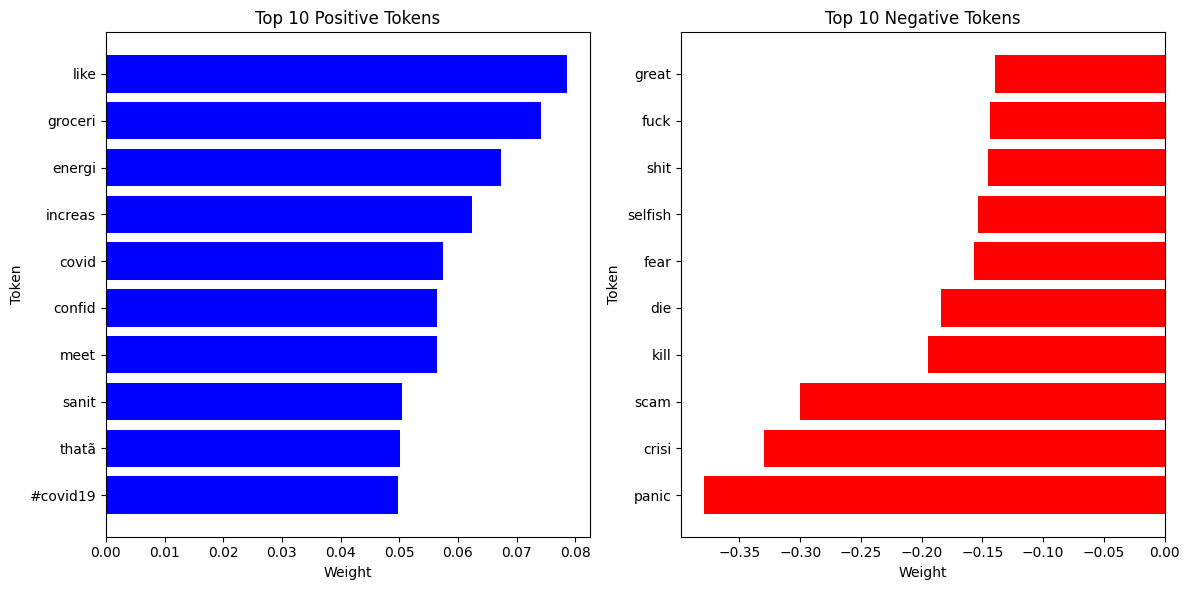

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(top_positive_tokens, clf.coef_[0][top_positive_indices], color='blue')
plt.xlabel('Weight')
plt.ylabel('Token')
plt.title('Top 10 Positive Tokens')

plt.subplot(1, 2, 2)
plt.barh(top_negative_tokens, clf.coef_[0][top_negative_indices], color='red')
plt.xlabel('Weight')
plt.ylabel('Token')
plt.title('Top 10 Negative Tokens')

plt.tight_layout()
plt.show()

**Токены в целом являются логичными и выражают эмоции и чувства**

## Другие признаки

Изучение признаков UserName и ScreenName

In [ ]:
train[['UserName', 'ScreenName']]

,UserName,ScreenName
25621,35178,80130
30135,40819,85771
28899,39249,84201
5989,11068,56020
4367,9109,54061
...,...,...
20757,29120,74072
32103,43291,88243
30403,41159,86111
21243,29702,74654


**Эти признаки не являются полезными, поскольку они являются идентификаторами, не несущими никакой смысловой нагрузки**--